In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os 
import sys
sys.path.insert(1, "/home/zxz147/git_forks/adversarial-robustness-toolbox")
sys.path.insert(1, "/home/zxz147/projects/De-Certification")
import numpy as np 
import matplotlib.pyplot as plt
import argparse
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torch.backends.cudnn as cudnn
from torchvision.datasets import CIFAR10
from torchvision import transforms

from art.attacks.evasion.boundary_orig import BoundaryAttackOrig
from art.attacks.evasion.boundary_cert import BoundaryAttackCert
from art.estimators.classification import PyTorchClassifier
from art.utils import load_cifar10, to_categorical

from smoothing.architectures import get_architecture
import models.resnet as resnet

In [2]:
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    # npimg = img   # convert from tensor
    # plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    # plt.show()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [3]:
smoothed=False
model_path = "/home/zxz147/git_clones/pytorch_resnet_cifar10/save_resnet110/checkpoint.th"
smoothed_path = "/home/zxz147/git_clones/adversarial-robustness-toolbox/test/de-certification/models/cifar10/resnet110/noise_0.50/checkpoint.pth.tar"
model_architecture = "cifar_resnet110"
dataset = "cifar10"
data_root = "/data/zxz147/cifar/cifar10/cifar-10-batches-py"

torch.cuda.is_available()

# model_resnet110 = torch.nn.DataParallel(resnet.__dict__["resnet110"]())
# model_resnet110.cuda()
# checkpoint = torch.load(model_path)
# model_resnet110.load_state_dict(checkpoint["state_dict"])

True

In [4]:
def load_classifier(checkpoint_path: str, smoothed: bool = False): 
    base_checkpoint = torch.load(checkpoint_path)
    if smoothed: 
        base_classifier = get_architecture(base_checkpoint["arch"], "cifar10")
    else: 
        base_classifier = torch.nn.DataParallel(resnet.__dict__["resnet110"]())
    base_classifier.load_state_dict(base_checkpoint["state_dict"])
    return base_classifier

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_cifar10()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
base_classifier = load_classifier(smoothed_path, True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_classifier.parameters(), lr=0.01)
pytorch_classifier = PyTorchClassifier(
    model=base_classifier, 
    clip_values=(min_pixel_value, max_pixel_value), 
    loss=criterion, 
    optimizer=optimizer, 
    input_shape=(3, 32, 32), 
    nb_classes=10)

In [94]:
pytorch_classifier.fit(x_train, y_train, batch_size=100, epochs=200)

KeyboardInterrupt: 

In [ ]:
pytorch_classifier.save(filename="cifar10-resnet110-fitted", path="/home/zxz147/projects/De-Certification/models/cifar10/resnet110")

In [6]:
predictions = pytorch_classifier.predict(x_test, training_mode=False)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

predictions = pytorch_classifier.predict(x_train)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
print("Accuracy on benign train examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 60.14000000000001%
Accuracy on benign train examples: 64.7%


Init image (cat): 3


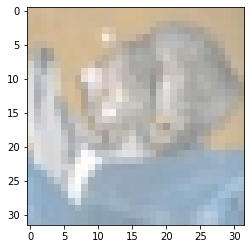

Target image (dog): 5


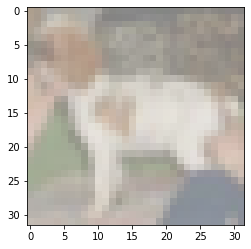

In [7]:
# Obtaining the init (cat) and target (dog) images. 
img_init, img_targ = None, None
imgs_found = [False, False]

for img, label in zip(x_test, y_test):
    if np.argmax(label) == 3 and not imgs_found[0]: 
        img_init = img
        imgs_found[0] = True
    if np.argmax(label) == 5 and not imgs_found[1]: 
        img_targ = img
        imgs_found[1] = True

print("Init image (cat): {}".format(np.argmax(pytorch_classifier.predict(np.expand_dims(img_init, 0)))))
imshow(img_init)
print("Target image (dog): {}".format(np.argmax(pytorch_classifier.predict(np.expand_dims(img_targ, 0)))))
imshow(img_targ)

In [11]:
attack = BoundaryAttackOrig(estimator=pytorch_classifier, targeted=False, max_iter=10, delta=0.001, epsilon=0.001)
iter_step=200
x_adv = None
for i in range(20):
    x_adv = attack.generate(x=np.array([img_targ[..., ::-1]]), x_adv_init=x_adv)

    #clear_output()
    print(i, " Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - img_targ[..., ::-1], [-1])),
          "and class label %d." % np.argmax(pytorch_classifier.predict(x_adv)[0]))
    # plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    # plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break



Number of queries used: 22
0  Adversarial image at step 0. L2 error 18.893984 and class label 0.




Number of queries used: 500
1  Adversarial image at step 200. L2 error 2.8123543 and class label 4.




Number of queries used: 955
2  Adversarial image at step 400. L2 error 2.050219 and class label 4.




Number of queries used: 1409
3  Adversarial image at step 600. L2 error 1.7023753 and class label 4.




Number of queries used: 1872
4  Adversarial image at step 800. L2 error 1.5224549 and class label 4.




Number of queries used: 2339
5  Adversarial image at step 1000. L2 error 1.4102489 and class label 4.




Number of queries used: 2812
6  Adversarial image at step 1200. L2 error 1.325851 and class label 4.




Number of queries used: 3271
7  Adversarial image at step 1400. L2 error 1.2571018 and class label 4.




Number of queries used: 3735
8  Adversarial image at step 1600. L2 error 1.2134334 and class label 4.




Number of queries used: 4184
9  Adversarial image at step 1800. L2 error 1.1754391 and class label 4.




Number of queries used: 4648
10  Adversarial image at step 2000. L2 error 1.1471463 and class label 4.




Number of queries used: 5108
11  Adversarial image at step 2200. L2 error 1.1216174 and class label 4.




Number of queries used: 5561
12  Adversarial image at step 2400. L2 error 1.1011815 and class label 4.




Number of queries used: 6029
13  Adversarial image at step 2600. L2 error 1.0854176 and class label 4.




Number of queries used: 6479
14  Adversarial image at step 2800. L2 error 1.0719184 and class label 4.




Number of queries used: 6942
15  Adversarial image at step 3000. L2 error 1.0608287 and class label 4.




Number of queries used: 7415
16  Adversarial image at step 3200. L2 error 1.0504327 and class label 4.




Number of queries used: 7894
17  Adversarial image at step 3400. L2 error 1.0420943 and class label 4.




Number of queries used: 8352
18  Adversarial image at step 3600. L2 error 1.0350535 and class label 4.




Number of queries used: 8810
19  Adversarial image at step 3800. L2 error 1.0282383 and class label 4.


In [11]:
attack = BoundaryAttackCert(estimator=pytorch_classifier, targeted=True, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = np.array([img_init[..., ::-1]])

for i in range(20):
    x_adv = attack.generate(x=np.array([img_targ[..., ::-1]]), y=to_categorical([8], 10), x_adv_init=x_adv)
    #clear_output()    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - img_targ[..., ::-1], [-1])),
          "and class label %d." % np.argmax(pytorch_classifier.predict(x_adv)[0]))
    # plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    # plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

AttributeError: 'PyTorchClassifier' object has no attribute 'eval'